# Image Vector Comparisson

Fernando Morales and Andres Kaleb

In [2]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import FeatureHasher


In [3]:
import numpy as np
import os
import json  

## Vector extraction from images

In [4]:
def extract_features(image_path, image_size=(100, 100), pixels_per_cell=(16, 16), cells_per_block=(4, 4), orientations=9):
    
    image = imread(image_path, as_gray=True)
    image_resized = resize(image, image_size)
    features, hog_image = hog(image_resized, orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              visualize=True, feature_vector=True)
    #features / np.linalg.norm(features)
    return features


In [28]:
images_root = "Imagenes\GoldenGate"
image_data_list = []
i = 0
for files in (os.listdir(images_root)):
    if files.endswith('.jpg'):
        image_path = os.path.join(images_root, files)
        feat = extract_features(image_path)
        image_data = {
            "id": str(i),
            "image": (feat.tolist()),  
            "path": image_path
        }
        i+=1
        print(str(feat.tolist()))
        image_data_list.append(image_data)

json_data = json.dumps(image_data_list, indent=4)

[0.0007211223232963975, 0.0, 0.0012523686618930517, 0.008863797990810121, 0.0557245736505908, 0.002949660801753545, 0.00039590556961977105, 0.0, 0.0, 0.013971458903944963, 0.014815763916203796, 0.04813750540974188, 0.08335920611269441, 0.03654158981701906, 0.02299649963939258, 0.007514046290203909, 0.009567897536519234, 0.015672549985820267, 0.015436855281502085, 0.02216153581518939, 0.0, 0.018940134471142785, 0.030340686227285932, 0.029774393423292498, 0.01303822270610817, 0.0, 0.028173072380427946, 0.0009759405153840465, 0.00023475832709781038, 0.00443198318142087, 0.023623472493466646, 0.02967544909917654, 0.0015344370792558183, 0.0, 0.0002054960464345555, 0.0, 0.006625476347714327, 0.08997037468183135, 0.13171588731592623, 0.05219415504215469, 0.07462193086219318, 0.00964303067254702, 0.0015667690261565146, 0.0009432200250336698, 0.0011474595279103291, 0.21430042831875523, 0.12264446354546651, 0.11575565795323055, 0.13052118703589066, 0.12453346550285059, 0.06313561854265656, 0.028

In [61]:
with open("json_im", "w") as json_file:
    json.dump(json_data, json_file)

# Azure cognitive

In [11]:
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient, SearchIndexingBufferedSender  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import (
    VectorizedQuery,
)


from azure.search.documents.indexes.models import (  
    ExhaustiveKnnAlgorithmConfiguration,
    ExhaustiveKnnParameters,
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    
    SearchField,  
    VectorSearch,  
    HnswAlgorithmConfiguration,
    HnswParameters,  
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
    SearchIndex,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    VectorSearch,
    ExhaustiveKnnParameters,
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SearchField,  
    VectorSearch,  
    HnswParameters,  
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchAlgorithmMetric,
    VectorSearchProfile,
)  

from dotenv import load_dotenv  
import os
import logging
import json
import pandas as pd

In [ ]:
connect_str = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
service_endpoint = os.getenv("AZURE_STORAGE_SERVICE_ENDPOINT")

index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
key = os.getenv("AZURE_SEARCH_KEY")


In [32]:

credential = AzureKeyCredential(key)


# Crea Index

In [232]:
index_client = SearchIndexClient(
    endpoint=service_endpoint, credential=credential)
fields = [
            SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
            SearchableField(name="path", type=SearchFieldDataType.String),
            SearchField(name="image", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                        searchable=True, vector_search_dimensions=1296, vector_search_profile_name="myHnswProfile"),
        ]

vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw", 
            
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(
                m=4,
                ef_construction=100,
                ef_search=100,
                metric=VectorSearchAlgorithmMetric.COSINE
            )
        ),
        ExhaustiveKnnAlgorithmConfiguration(
            name="myExhaustiveKnn",
            kind=VectorSearchAlgorithmKind.EXHAUSTIVE_KNN,
            parameters=ExhaustiveKnnParameters(
                metric=VectorSearchAlgorithmMetric.DOT_PRODUCT
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw",
            
        ),
        VectorSearchProfile(
            name="myExhaustiveKnnProfile",
            algorithm_configuration_name="myExhaustiveKnn",
        )
    ]
)



In [233]:
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')


 busquedaimagenes created


In [234]:

with SearchIndexingBufferedSender(  
    endpoint=service_endpoint,  
    index_name=index_name,  
    credential=credential,  
) as batch_client:  
    
    batch_client.upload_documents(documents=image_data_list) 

print(f"Uploaded {len(image_data_list)} documents in total")  


Uploaded 10 documents in total


# Image serching with azure search

In [12]:
import matplotlib.pyplot as plt

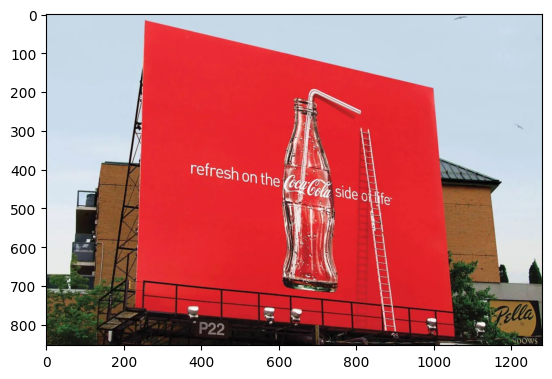

In [14]:
path = "Imagenes\Coca\c1.jpg"
og = plt.imread(path)
plt.imshow(og)
embedding = extract_features(path)


In [58]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)

vector_query_content = VectorizedQuery(vector=(embedding.tolist()), 
                                k_nearest_neighbors=3, 
                                fields= "image",
                                exhaustive=False)

results = search_client.search(  
    vector_queries=[vector_query_content],
    select=["path", "id", "image"],
    top= 2
)


Vect\Vect\Imagenes\GoldenGate\g1.jpg


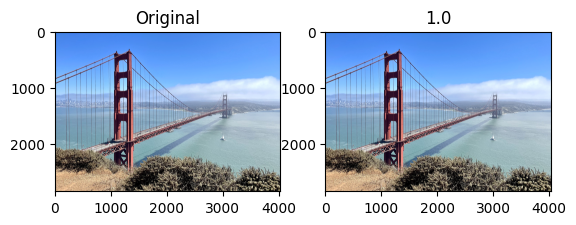

Vect\Vect\Imagenes\GoldenGate\g2.jpg


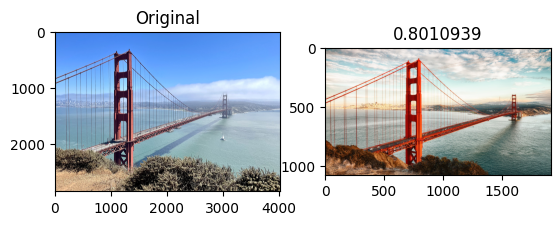

In [59]:
for result in results:
    print(result["path"])
    similar = plt.imread(result["path"])
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(og)
    #
    plt.subplot(1, 2, 2)
    plt.imshow(similar)
    plt.title(result["@search.score"])
    plt.show()


# Python based search

In [121]:
import numpy as np
import seaborn as sbn
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [76]:
with open('json_im.json', 'r') as file:
    json_data = json.load(file)

In [77]:
data = json.loads(json_data)
df = pd.DataFrame(data)
df.head()
X = np.array(df["image"].tolist())


#### Vector clustering

In [81]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

print(cluster_centers)
print(cluster_labels)


[[0.00462746 0.00195367 0.00342117 ... 0.05278596 0.07678275 0.09834657]
 [0.01235844 0.02513398 0.08034701 ... 0.06562093 0.02990649 0.02100261]
 [0.02630283 0.05464047 0.03552749 ... 0.0804117  0.0606842  0.0683386 ]]
[0 2 2 2 0 2 2 1 1 1]


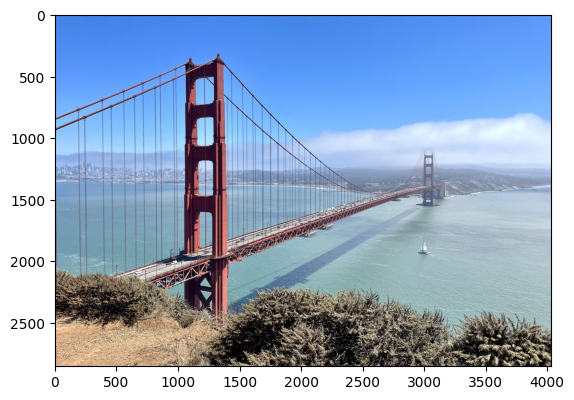

In [82]:
path = "Vect\Vect\Imagenes\GoldenGate\g1.jpg"
og = plt.imread(path)
plt.imshow(og)
embedding = extract_features(path)

### Vector distances

In [83]:
distances = np.linalg.norm(X - embedding, axis=1)
print(distances.T)    
df["path"]

[3.35035094 2.95763258 2.97541122 3.21995266 3.08868642 3.14316483
 3.05192779 0.         2.1140661  2.34982942]


0          Imagenes\Coca\c1.jpg
1          Imagenes\Coca\c2.jpg
2          Imagenes\Coca\c3.jpg
3       Imagenes\Soumaya\s1.jpg
4       Imagenes\Soumaya\s2.jpg
5       Imagenes\Soumaya\s3.jpg
6       Imagenes\Soumaya\s4.jpg
7    Imagenes\GoldenGate\g1.jpg
8    Imagenes\GoldenGate\g2.jpg
9    Imagenes\GoldenGate\g3.jpg
Name: path, dtype: object

### vector cosine similitude

In [84]:
similarities = cosine_similarity(X, [embedding])
print(similarities)

[[0.37639714]
 [0.51402275]
 [0.50816267]
 [0.42399472]
 [0.4700009 ]
 [0.45113971]
 [0.48254093]
 [1.        ]
 [0.75170692]
 [0.69323898]]


In [86]:
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture


In [145]:
# define the model
gaussian_model = GaussianMixture(n_components=3, covariance_type = "tied")
gaussian_model.fit(X)



GaussianMixture(covariance_type='tied', n_components=3)

In [146]:
labels = gaussian_model.predict(X)
labels

array([1, 1, 2, 1, 2, 1, 2, 0, 0, 0], dtype=int64)

In [114]:
label = []
for index, row in df.iterrows():
    if "Coca" in row['path']:
        label.append("0")
    elif "Soumaya" in row["path"]:
        label.append("1")
    else:
        label.append("2")

In [116]:
df["label"] = label

In [131]:
df2 = pd.DataFrame(np.array(X))
df2["label"] = label

In [132]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,1287,1288,1289,1290,1291,1292,1293,1294,1295,label
0,0.001434,0.001279,9.686996e-04,8.805645e-04,0.001967,1.082858e-03,7.595911e-04,0.000771,1.351913e-03,2.461359e-01,...,0.066114,0.088226,0.070985,0.090042,0.136230,0.068972,0.077143,0.114237,0.161888,0
1,0.000048,0.000000,3.065944e-18,3.427830e-18,0.000564,2.423842e-18,1.073080e-17,0.000000,7.477332e-07,5.636670e-17,...,0.021566,0.031963,0.038921,0.197132,0.084659,0.031120,0.025451,0.009984,0.005674,0
2,0.014256,0.008797,8.828445e-03,4.483984e-03,0.004547,1.785813e-03,6.769693e-03,0.001595,9.697515e-03,6.203928e-03,...,0.033646,0.022936,0.010000,0.026330,0.205053,0.205053,0.036203,0.019855,0.071711,0
3,0.082982,0.203226,1.136587e-01,1.029236e-01,0.136252,1.338203e-01,3.820858e-02,0.021354,4.437299e-02,1.141186e-01,...,0.159875,0.072337,0.048187,0.057604,0.209317,0.053332,0.135882,0.055474,0.096061,1
4,0.007821,0.002628,5.873635e-03,2.635042e-02,0.047169,3.159195e-02,2.131673e-02,0.009952,4.010446e-03,8.781144e-03,...,0.052772,0.039315,0.034024,0.049804,0.119885,0.050102,0.028429,0.039329,0.034805,1
